In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import copy
from os import listdir, path
from os.path import isfile, join

In [2]:
class ImageProcess(object):
    """Process and calibrate images from camera"""
    
    def __init__(self, calibrate = False, matrixPath = None, size= 1000):
        """Creates an object of image correction """
        
        if matrixPath == None:
            self.matrixPath = "calibration_data.npz"
        else:
            self.matrixPath = matrixPath+".npz"
        
        # setup parameters 
        self.size = size
        self.imageReadPath=  "./calibrationData"
        
        if calibrate:
            self.calibrateCamera()
            
        #loading the matrix calibration data
        calibrationData = np.load(self.matrixPath)
        distCoeff, intrinsic_matrix = calibrationData.files
        self.intrinsic_matrix = calibrationData[intrinsic_matrix]
        self.distCoeff = calibrationData[distCoeff]
    
    def readImages(self, path = None, crop= False, size = None):
        """reads images from a giben path and crop them with a desired size"""
        if path == None:
            path = self.imageReadPath
        if size == None:
            size = self.size
        names = [join(path, f) for f in listdir(path) 
                                     if (isfile(join(path, f)) 
                                    and (f[-4:]==".jpg" or f[-4:]==".png"))]

        self.sourceImages = [cv2.imread(name) for name in names ]
        self.images = copy.deepcopy(self.sourceImages)
        self.h,self.w,_ = self.sourceImages[0].shape
        
        if crop:
            wC = self.w//2
            hC = self.h//2
            self.images = [img[hC-size//2:hC+size//2, wC-size//2:wC+size//2] for img in self.images]
        
        return self.images
        
    def lensCorrection(self, images= None, save = False):
        """applies lens correction to the images"""
        
        if type(images) != np.ndarray and type(images) != list: 
            images = self.readImages()
        if type(images) != list: 
            images = [images]
                    
        self.corrected = [cv2.undistort(img, self.intrinsic_matrix, self.distCoeff, None) for img in images]
        print (len(self.corrected))
        if save:
            for i in range (len(self.corrected)):
                name = "corrected{}.jpg".format(i)
                cv2.imwrite(name,self.corrected[i])
                
        return self.corrected
    
    def saveImages (self, images):
        """Saves given images"""
        if images== None:
            return
        if type(images) != list: images = [images]
        
        for i in range (len(images)):
            name = "corrected{}.jpg".format(i)
            cv2.imwrite(name,images[i])
        return
    
    def calibrateCamera(self):
        """calibrate camera based on a set of given images"""
        # based on: https://www.theeminentcodfish.com/gopro-calibration/
        
        images = self.readImages()
        n_boards = len(images)
        board_w = 9
        board_h= 6
        board_dim= 25
        h,w,_ = images[0].shape
        image_size = (w,h)
        print (image_size)


        board_n = board_w * board_h
        opts = []
        ipts = []
        npts = np.zeros((n_boards, 1), np.int32)
        intrinsic_matrix = np.zeros((3, 3), np.float32)
        distCoeffs = np.zeros((5, 1), np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

        # prepare object points based on the actual dimensions of the calibration board
        # like (0,0,0), (25,0,0), (50,0,0) ....,(200,125,0)
        
        objp = np.zeros((board_h*board_w,3), np.float32)
        objp[:,:2] = np.mgrid[0:(board_w*board_dim):board_dim,0:(board_h*board_dim):board_dim].T.reshape(-1,2)

        #Loop through the images.  Find checkerboard corners and save the data to ipts.
        for i in range(1, n_boards + 1):

            #Loading images
            print ('Loading... Calibration image' + str(i))
            image = images[i-1]

            #Converting to grayscale
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

            #Find chessboard corners
            found, corners = cv2.findChessboardCorners(grey_image, (board_w,board_h),cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE)
            print (found)

            if found == True:

                #Add the "true" checkerboard corners
                opts.append(objp)

                #Improve the accuracy of the checkerboard corners found in the image and save them to the ipts variable.
                cv2.cornerSubPix(grey_image, corners, (20, 20), (-1, -1), criteria)
                ipts.append(corners)

                #Draw chessboard corners
                cv2.drawChessboardCorners(image, (board_w, board_h), corners, found)

                #Show the image with the chessboard corners overlaid.
                plt.imshow(image)
                plt.show()

        print ('')
        print ('Finished processes images.')

        #Calibrate the camera
        print ('Running Calibrations...')
        print(' ')
        ret, intrinsic_matrix, distCoeff, rvecs, tvecs = cv2.calibrateCamera(opts, ipts, grey_image.shape[::-1],None,None)

        #Save matrices
        print('Intrinsic Matrix: ')
        print(str(intrinsic_matrix))
        print(' ')
        print('Distortion Coefficients: ')
        print(str(distCoeff))
        print(' ') 

        #Save data
        print ('Saving data file...')
        np.savez(self.matrixPath, distCoeff=distCoeff, intrinsic_matrix=intrinsic_matrix)
        print ('Calibration complete')
        #Calculate the total reprojection error.  The closer to zero the better.
        tot_error = 0
        for i in range(len(opts)):
            imgpoints2, _ = cv2.projectPoints(opts[i], rvecs[i], tvecs[i], intrinsic_matrix, distCoeff)
            error = cv2.norm(ipts[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
            tot_error += error

        print ("total reprojection error: ", tot_error/len(opts))

(1920, 1080)
Loading... Calibration image1
True


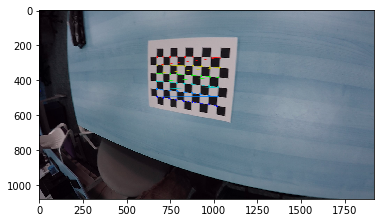

Loading... Calibration image2
True


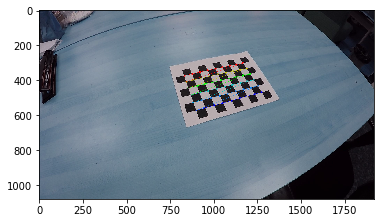

Loading... Calibration image3
True


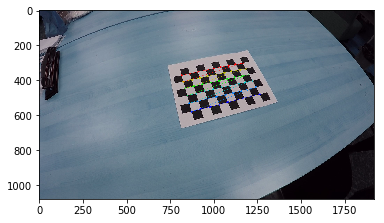

Loading... Calibration image4
True


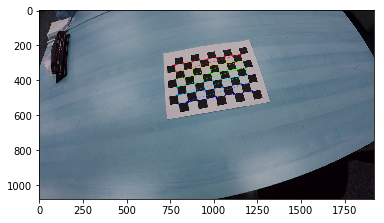

Loading... Calibration image5
True


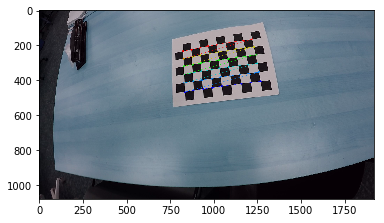

Loading... Calibration image6
True


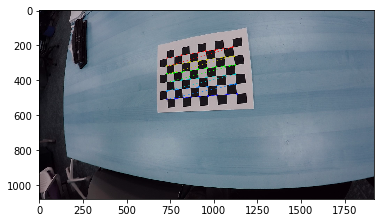

Loading... Calibration image7
True


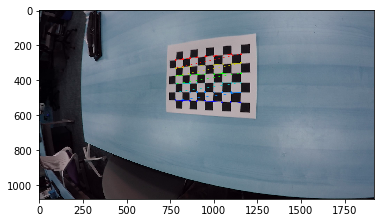

Loading... Calibration image8
True


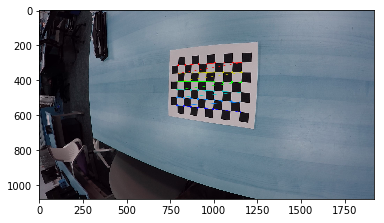

Loading... Calibration image9
True


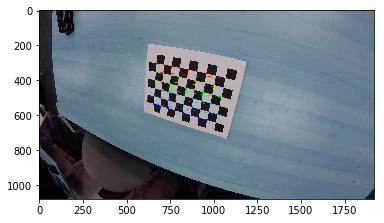

Loading... Calibration image10
True


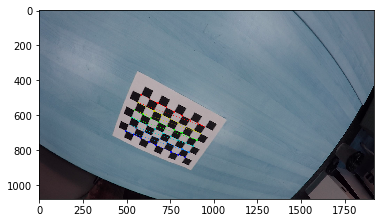

Loading... Calibration image11
True


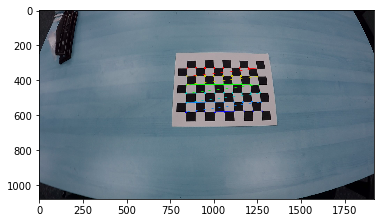

Loading... Calibration image12
True


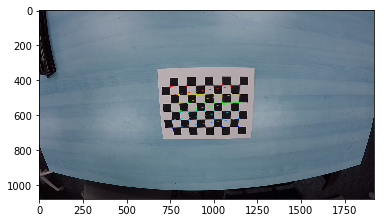

Loading... Calibration image13
True


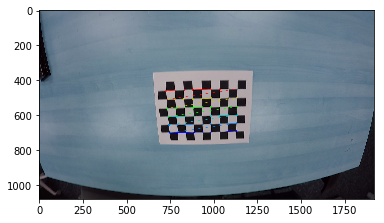

Loading... Calibration image14
True


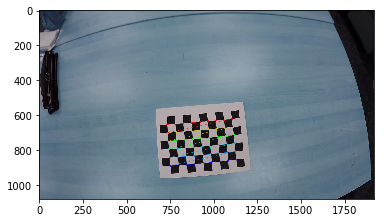

Loading... Calibration image15
True


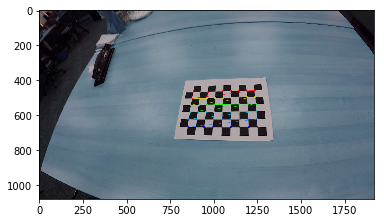

Loading... Calibration image16
True


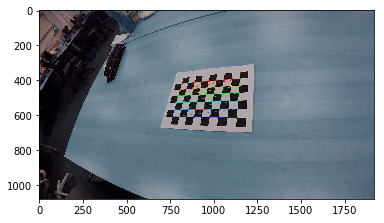

Loading... Calibration image17
True


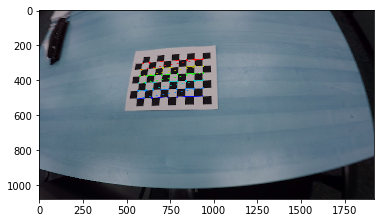

Loading... Calibration image18
True


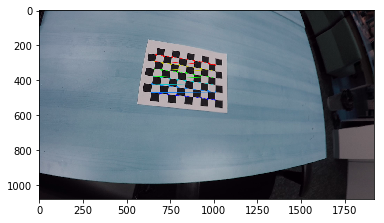

Loading... Calibration image19
True


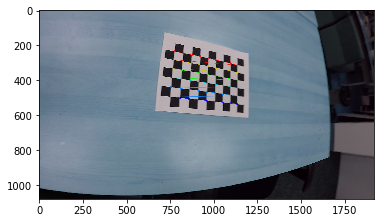

Loading... Calibration image20
True


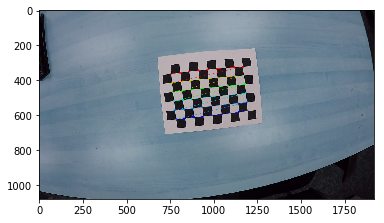

Loading... Calibration image21
True


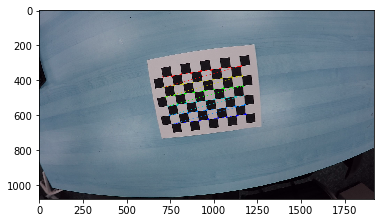

Loading... Calibration image22
True


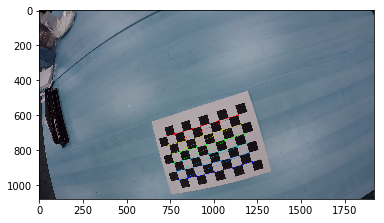


Finished processes images.
Running Calibrations...
 
Intrinsic Matrix: 
[[ 881.83260335    0.          961.75323996]
 [   0.          883.50926405  578.1028897 ]
 [   0.            0.            1.        ]]
 
Distortion Coefficients: 
[[-0.28624528  0.12643291 -0.00222566 -0.00052379  0.02287055]]
 
Saving data file...
Calibration complete
total reprojection error:  0.048313161041275914
Wall time: 6.7 s


In [3]:
%%time
cor = ImageProcess(calibrate=True)

22
1


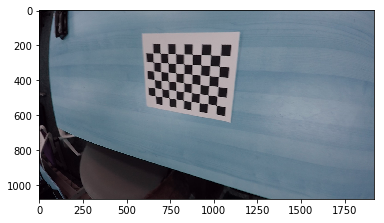

Wall time: 1.57 s


In [4]:
%%time
a= cor.lensCorrection()
pic = cor.lensCorrection(images = cor.images[0])
plt.imshow(pic[0])
plt.show()